# Explore the reference network


- [Crossref](https://www.crossref.org/) provides an API to get the references of a publication ([rest-api-doc](https://github.com/CrossRef/rest-api-doc)).


- Go down the references for a fixed number of steps (for example 3), then keep only the articles which have been visited more than N times (for examples 3 times), and draw the upward graph starting from these articles. 

## To do:
- resolve identical label
- stats:  n ref vs n citation, review vs foundational

- disconnected component for the 1st generation references: coloring 

- use 'store' from scopus manual export + [query ref resolver](https://www.crossref.org/labs/resolving-citations-we-dont-need-no-stinkin-parser/)

- get country/city/univ  get flag/favicon





In [3]:
#%load_ext autoreload
#%autoreload 2

import crossrefexp as exp

In [4]:
# Create the interface to acces metadata
store = exp.MetaDataStore('data/gen4_Cochard2010.pickle')

857 metadata loaded from `data/gen4_Cochard2010.pickle`


In [ ]:
store.reset()

In [5]:
metadata = store.get( '10.1063/1.3284082'  )
metadata.printinfo()

(2010) Constitutive modeling of intrinsic silicon monocrystals in easy glide
   J. Cochard et al. - Journal of Applied Physics
   http://dx.doi.org/10.1063/1.3284082


In [13]:
metadata

{'DOI': '10.1063/1.3284082',
 'ISSN': ['0021-8979', '1089-7550'],
 'URL': 'http://dx.doi.org/10.1063/1.3284082',
 'alternative-id': ['10.1063/1.3284082'],
 'author': [{'affiliation': [],
   'family': 'Cochard',
   'given': 'J.',
   'sequence': 'first'},
  {'affiliation': [],
   'family': 'Yonenaga',
   'given': 'I.',
   'sequence': 'additional'},
  {'affiliation': [],
   'family': 'Gouttebroze',
   'given': 'S.',
   'sequence': 'additional'},
  {'affiliation': [],
   'family': 'M’Hamdi',
   'given': 'M.',
   'sequence': 'additional'},
  {'affiliation': [],
   'family': 'Zhang',
   'given': 'Z. L.',
   'sequence': 'additional'}],
 'container-title': ['Journal of Applied Physics'],
 'content-domain': {'crossmark-restriction': False, 'domain': []},
 'created': {'date-parts': [[2010, 2, 8]],
  'date-time': '2010-02-08T23:21:22Z',
  'timestamp': 1265671282000},
 'deposited': {'date-parts': [[2017, 6, 19]],
  'date-time': '2017-06-19T04:35:21Z',
  'timestamp': 1497846921000},
 'indexed': {'d

In [8]:
gr = store.build_a_refgraph( '10.1063/1.3284082', gen=2 )
for doi, citedby_count in gr.most_cited()[:10]:
    print( getlabel(doi), citedby_count, store.get(doi)['URL'])

  0/1: - done -            
33 nodes in the graph. The last generation number is 1.
  0/32:   1/32:   2/32:   3/32:   4/32:   5/32:   6/32:   7/32:   8/32:   9/32:  10/32:  11/32:  12/32:  13/32:  14/32:  15/32:  16/32:  17/32:  18/32:  19/32:  20/32:  21/32:  22/32:  23/32:  24/32:  25/32:  26/32:  27/32:  28/32:  29/32:  30/32:  31/32: - done -            
160 nodes in the graph. The last generation number is 2.
Sumino1981 4 http://dx.doi.org/10.1080/01418618108235812
Alexander1969 4 http://dx.doi.org/10.1016/s0081-1947(08)60031-4
Imai1983 4 http://dx.doi.org/10.1080/01418618308245248
George1972 3 http://dx.doi.org/10.1002/pssb.2220530209
Haas1960 2 http://dx.doi.org/10.1016/0022-3697(60)90106-2
Haasen1962 2 http://dx.doi.org/10.1007/bf01378125
Omri1987 2 http://dx.doi.org/10.1080/01418618708214371
Yonenaga1978 2 http://dx.doi.org/10.1002/pssa.2210500239
George1979 2 http://dx.doi.org/10.1002/pssa.2210530216
Sumino1983 2 http://dx.doi.org/10.1080/01418618308245262


In [12]:
gr = store.build_a_refgraph( '10.1063/1.3284082', gen=3 )
for doi, citedby_count in gr.most_cited()[:10]:
    print( getlabel(doi), citedby_count, 'gen%i'%gr[doi]['gen'], store.get(doi)['URL'])

  0/1: - done -            
33 nodes in the graph. The last generation number is 1.
  0/32:   1/32:   2/32:   3/32:   4/32:   5/32:   6/32:   7/32:   8/32:   9/32:  10/32:  11/32:  12/32:  13/32:  14/32:  15/32:  16/32:  17/32:  18/32:  19/32:  20/32:  21/32:  22/32:  23/32:  24/32:  25/32:  26/32:  27/32:  28/32:  29/32:  30/32:  31/32: - done -            
160 nodes in the graph. The last generation number is 2.
  0/127:   1/127:   2/127:   3/127:   4/127:   5/127:   6/127:   7/127:   8/127:   9/127:  10/127:  11/127:  12/127:  13/127:  14/127:  15/127:  16/127:  17/127:  18/127:  19/127:  20/127:  21/127:  22/127:  23/127:  24/127:  25/127:  26/127:  27/127:  28/127:  29/127:  30/127:  31/127:  32/127:  33/127:  34/127:  35/127:  36/127:  37/127:  38/127:  39/127:  40/127:  41/127:  42/127:  43/127:  44/127:  45/127:  46/127:  47/127:  48/127:  49/127:  50/127:  51/127:  52/127:  53/127:  54/127:  55/127:  56/127:  57/127:  58/127:  59/127:  60/127:  61/127:  62/127:  63/127:  64/12

In [ ]:
# Create a reference graph starting at the given DOI:
gr = exp.ReferenceGraph( '10.1063/1.3284082' )
gr

In [ ]:
# Expand the graph for N-generation
store.grow( gr, N=2 )

In [14]:
from graphviz import Digraph

In [15]:
def build_graph( doi, gen=2, top=3 ):
    # Create a reference graph starting at the given DOI:
    gr = exp.ReferenceGraph( doi )
    
    # Expand the graph for N-generation
    store.grow( gr, N=gen )
    
    # Build the upward graph starting from the top-N cited articles
    nodes, links = gr.upward_graph( top )
    remaining_links = exp.filter_double_links( links )

    no_weight_links = [ link for link in links if link not in remaining_links ]
    
    return nodes, remaining_links, no_weight_links

In [16]:
# Build the upward graph starting from the top-N cited articles
nodes, links = gr.upward_graph(2)
remaining_links = exp.filter_double_links( links )

no_weight_links = [ link for link in links if link not in remaining_links ]

def getlabel(doi):
    return store.get(doi).label()

color_list = ['red', 'gold1', 'cyan3', 'darkorchid2', 'chartreuse2']
def getcolor(doi):
    return color_list[ gr[doi]['gen'] ]

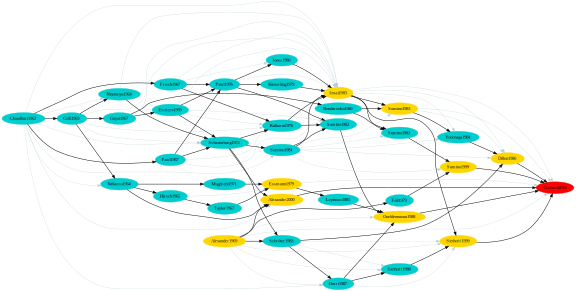

In [17]:
graph = exp.built_graphviz( nodes, remaining_links, getlabel, getcolor, secondary_links=no_weight_links )
graph.render()
graph

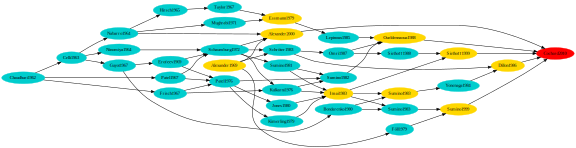

In [18]:
remaining_links = exp.filter_double_links( links )
exp.built_graphviz( nodes, remaining_links, getlabel, getcolor )

In [19]:
nodes, remaining_links, no_weight_links = build_graph( '10.1063/1.3284082', gen=2, top=5 )
exp.built_graphviz( nodes, remaining_links, getlabel, getcolor, secondary_links=no_weight_links )

AttributeError: 'MetaDataStore' object has no attribute 'grow'

In [ ]:
for doi, citedby_count in gr.most_cited()[:10]:
    print( getlabel(doi), citedby_count, store.get(doi)['URL'])

In [ ]:
gr